In [1]:
# import libraries and set paths
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, HTML, Image
import tabulate

output_fldrpath = "/media/disk1/forecast_wiki_traffic/output"


In [2]:
# load stored summary details data
d = pickle.load(open(output_fldrpath + "/summary_report_data.p", "rb"))
locals().update(d)
del d

# Project Overview

Kaggle recently hosted a competition using a time series dataset of page vistts to 145,063 articles on Wikipedia, with the competition titled [Web Traffic Time Series Forecasting](https://www.kaggle.com/c/web-traffic-time-series-forecasting). Kaggle provided the number of visits to each of those pages for 803 days (approximately 26 months) of daily history. The goal was to forecast the daily visits to those same pages for the next 60 days. The visits for each page of the next 60 days was not known at the time of the forecast, and was necessary to wait 60 days after the competition end to collect the observed values for the 60-day test data. Results were scored by SMAPE. Below is an example of one of these 145,063 time series.

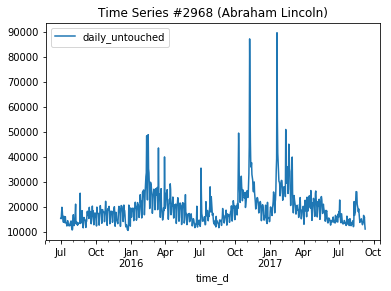

In [3]:
ex1d_plotdata.loc[:,["daily_untouched"]].plot(title="Time Series #2968 (Abraham Lincoln)")
plt.show()

The approach for this project was to create several different models and combine them with an ensemble model.

# Data Exploration

## Page Distributions

In addition to the 803 days worth of page views, each page is also tagged with the Wikipedia project, the access method, and the agent.

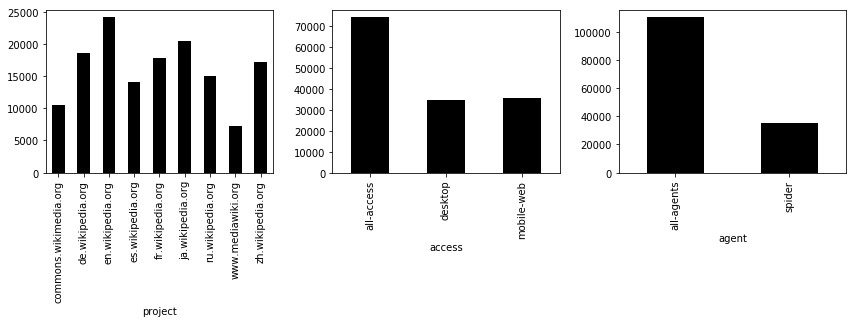

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(12,5))

p = page_to_id_map.groupby(["project"])["name"].count().plot(kind="bar", color="black", ax=ax[0])
p = page_to_id_map.groupby(["access"])["name"].count().plot(kind="bar", color="black", ax=ax[1])
p = page_to_id_map.groupby(["agent"])["name"].count().plot(kind="bar", color="black", ax=ax[2])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Missing Values

There are also missing values in the dataset, which could be either true missings because of data issues or they could be zero observations. Missing values that appear as a contiguous block from the beginning from the series are assumed to be from pages where the history does not exist far enough back, and are referred to as "short series." Missing values that occur between valid values are referred to as "holes."

In [5]:
missing_counts_by_obs_ratio = missing_counts_by_obs/missing_counts_by_obs.sum()
missing_counts_by_obs_ratio = missing_counts_by_obs_ratio.to_frame("ratio_of_obs")

In [6]:
Markdown("Of the observations in the dataset, {:.1f}% are missing values that are holes and {:.1f}% are missing values at the beginning of a short series".format(
    missing_counts_by_obs_ratio.loc["missing_hole", "ratio_of_obs"]*100, 
    missing_counts_by_obs_ratio.loc["missing_short", "ratio_of_obs"]*100))

Of the observations in the dataset, 2.0% are missing values that are holes and 4.1% are missing values at the beginning of a short series

In [7]:
display(HTML(missing_counts_by_obs_ratio.to_html()))

,ratio_of_obs
missing_type,
no_missing,0.939672
missing_short,0.040663
missing_hole,0.019665


In [8]:
missing_counts_by_ts_ratio = missing_counts_by_ts.index.get_level_values("missing_type").value_counts()/len(page_to_id_map)
missing_counts_by_ts_ratio = missing_counts_by_ts_ratio.to_frame("ratio_of_ts")
missing_counts_by_ts_ratio.drop(["no_missing"], axis=0, inplace=True)

In [9]:
Markdown("Of the time series in the dataset, {:.1f}% have at least one missing value that is a hole and {:.1f}% are short series".format(
    missing_counts_by_ts_ratio.loc["missing_hole", "ratio_of_ts"]*100, 
    missing_counts_by_ts_ratio.loc["missing_short", "ratio_of_ts"]*100))

Of the time series in the dataset, 13.1% have at least one missing value that is a hole and 14.3% are short series

In [10]:
display(HTML(missing_counts_by_ts_ratio.to_html()))

,ratio_of_ts
missing_short,0.142972
missing_hole,0.130764


## Seasonality

The data likely has a seasonal pattern, as can be seen in the chart below when aggregated to an overall level, with more page views in general during the weekends. Will try to incorporate this into models.

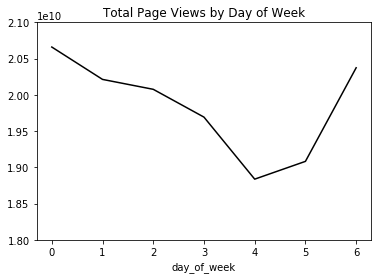

In [11]:
total_dayofweek_sum_plotdata = agg_stat_dayofweek_sum.groupby("day_of_week")["sum"].sum()

p = total_dayofweek_sum_plotdata.plot(kind="line", color="black", ylim=(1.8e10,2.1e10), title="Total Page Views by Day of Week")
plt.show(p)

## View Distributions

A fair number of time series have decent activity, with more than half having a median of 122 views per day, which may make fitting an ARIMA model worthwhile. For the those where there is as much activity, such as the 25% that have a median of 16 or less visits per day simple approaches such as means and medians or means and medians calculated off subsets may be beneficial.

In [12]:
pageview_median_distribution = pageview_median.describe().drop(["count","mean","std"], axis=0)
display(HTML(pageview_median_distribution.to_html()))

,median
min,0.0
25%,16.0
50%,122.0
75%,531.0
max,19440903.0


# Modeling Approach

## Splitting into Training, Validation, and Test Samples

For hyperparameter tuning and model selection, the first 743 observations of the 803 observations for each time series were used as the **training sample** and the last 60 days were held out to be the **validation sample**. The 60 day window size of the validation sample was chosen to match the 60 day forecast window.

Once hyperparameters are chosen, the model is fit with all 803 observations for each time series and then used to forecast the following 60 days, which forms the **testing sample**.

## Creating the Modeling Dataset

### Data Cleaning

**Outliers** were identified as observations that are more than two overall standard deviations from the 30-day center rolling average for that time seies. There were also **holes** in many of time series, where there is an NA value but valid observations before and after. It is unknown whether these NAs are data issues or if they are zero values, although zero values do appear in the data.

**Outliers and holes were cleaned by imputing** with the average of the prior day of week and following day of week. For example, if an outlier or hole was on a Wednesday, it would be imputed with the average value of the prior Wednesday and the following Wednesday. Imputing by the day of the week is done to preserve any weekly seasonality. If this was not possible because either those values were missing too, or if the outlier or hole occurs too close to the beginning or end of the series, then the outlier or hole was imputed with the rolling average.

Any negative page views were assumed to be data errors, and replaced with zeros.

The chart below shows the effect of cleaning up outliers for one time series.

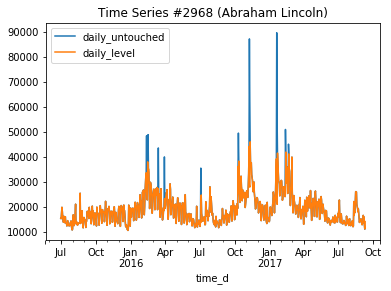

In [13]:
ex1d_plotdata.loc[:,["daily_untouched","daily_level"]].plot(title="Time Series #2968 (Abraham Lincoln)")
plt.show()

### Holiday Adjustments

A simple method to account for holidays was also applied. The effect of the holiday is removed before models are fit, and the effect is re-applied after the model forecast.

A short list of holidays that always fall on the same day were defined, along with the locales that they are associated with. Future enhancements could include holidays that may change days every year, for example, Labor Day which falls on the first Monday of September.

For holidays in the list where all the occurences of that holiday in the time series are outliers, save the ratio between the cleaned figure to the untouched figure as the adjustment factor to apply for projection.

Below is an example of adjusting for the Halloween holiday. This adjust will be un-applied after a forecast is made.

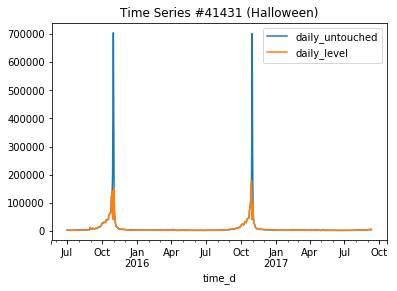

In [14]:
ex_halloween_d_plotdata.loc[:,["daily_untouched","daily_level"]].plot(title="Time Series #41431 (Halloween)")
plt.show()

### Data Transformations by Page

The clean and adjusted time series were then used to create four page-level data transformations for modeling. Models will be fit to each of these transformations.


| Transformation                    | Description                             |
| ---------------------------------:|:--------------------------------------- |
| Page Daily Level                  | Already have                            |
| Page Daily Week-over-Week Growth  | Convert daliy level to W-o-W            |
| Page Weekly Level                 | Sum daily level to weekly level         |
| Page Weekly Week-over-Week Growth | Convert weekly level to W-o-W           |

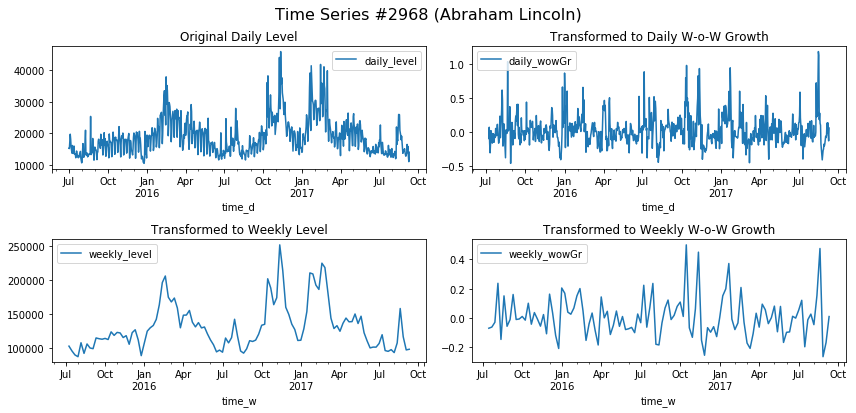

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle("Time Series #2968 (Abraham Lincoln)", fontsize=16)

ex1d_plotdata.loc[:,["daily_level"]].plot(title="Original Daily Level", ax=ax[0][0])
ex1d_plotdata.loc[:,["daily_wowGr"]].plot(title="Transformed to Daily W-o-W Growth", ax=ax[0][1])
ex1w_plotdata.loc[:,["weekly_level"]].plot(title="Transformed to Weekly Level", ax=ax[1][0])
ex1w_plotdata.loc[:,["weekly_wowGr"]].plot(title="Transformed to Weekly W-o-W Growth", ax=ax[1][1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Data Aggregations

Models were also fit at a more aggregated level, and results distributed back to the page level. Aggregations were done by taking the sum of visits by project, access, and agent.

Some of the component time series are short. To account for the downward bias:
1. Take the global median of all time series.
2. At each date, scale the summed value of the available series up by multiplying by the ratio of the sum of all global medians to sum of available medians.



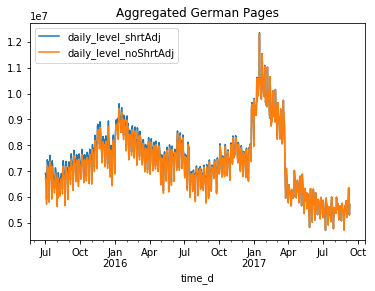

In [16]:
ex9d_plotdata.loc[:,["daily_level_shrtAdj","daily_level_noShrtAdj"]].plot(title="Aggregated German Pages")
plt.show()

| Transformation                          | Description           |
| ---------------------------------------:|:--------------------- |
| Aggregated Daily Level                  | Add up all the page visits for each combination of project, access, and agent for each day |
| Aggregated Daily Week-over-Week Growth  | Calculate the week-over-week growth rate of the above aggregation |
| Aggregated Weekly Level                 | Add up all the page visits for each combination of project, access, and agent for each week                      |
| Aggregated Weekly Week-over-Week Growth | Calculate the week-over-week growth rate of the above aggregation |

Models will be fit to these aggregated levels, and the forecasts will be re-distributed back to the individual page level.

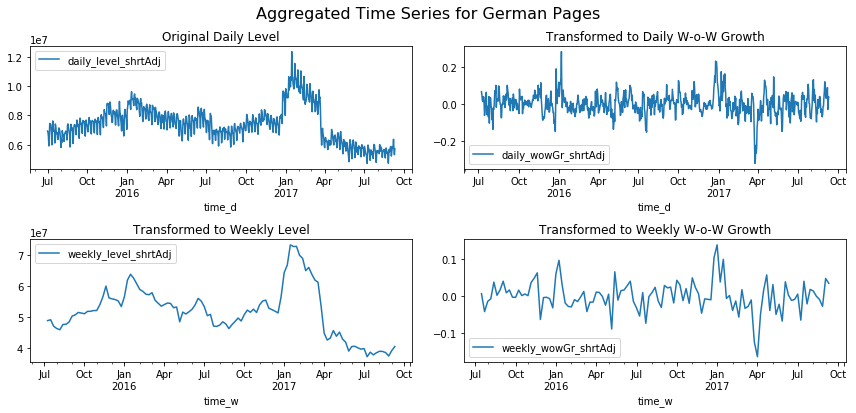

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(12,6))
fig.suptitle("Aggregated Time Series for German Pages", fontsize=16)

ex9d_plotdata.loc[:,["daily_level_shrtAdj"]].plot(title="Original Daily Level", ax=ax[0][0])
ex9d_plotdata.loc[:,["daily_wowGr_shrtAdj"]].plot(title="Transformed to Daily W-o-W Growth", ax=ax[0][1])
ex9w_plotdata.loc[:,["weekly_level_shrtAdj"]].plot(title="Transformed to Weekly Level", ax=ax[1][0])
ex9w_plotdata.loc[:,["weekly_wowGr_shrtAdj"]].plot(title="Transformed to Weekly W-o-W Growth", ax=ax[1][1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Finding Stationary Transformations

ARMA models assume that the data is stationary, and since the raw time series may not be stationary they need to first be transformed so that they are. The procedure followed is based off the one outlined in Hyndman and Khandakar (2008), for which in particular the log transformation is added. The following steps were followed to find a stationary transformation where possible. This is done by performing transformations one by one until one transformation passes the KPSS test. The KPSS test was used instead of the Dickey-Fuller test because the null hypothesis of the KPSS test is stationary, so will will tend us toward less transformations.

The KPSS test was applied in waterfall way to determine the order of differencing, order of seasonal differencing, and transformations. Transformations were only considered if d+D<=2 and D<=1. Do S=7 for daily, but S=0 for weekly since the seasonality would be long if did 52.

The KPSS test was performed in this order until a stationary transformation was found (null hypothesis is not rejected). This is done for these eight transformations.

1. d=0, D=0, untransformed
2. d=1, D=0, untransformed
3. d=0, D=1, untransformed (daily only)
4. d=1, D=1, untransformed (daily only)
5. d=2, D=0, untransformed
6. repeat above with log transformation
7. if still no stationary transformation at this point, flag it


The two plots below show the time series before the stationary transformation and after the stationary transformation for an example page, which in this case is a first difference. After the transformation, the series mean becomes much closer to constant and the variance is much more stable.

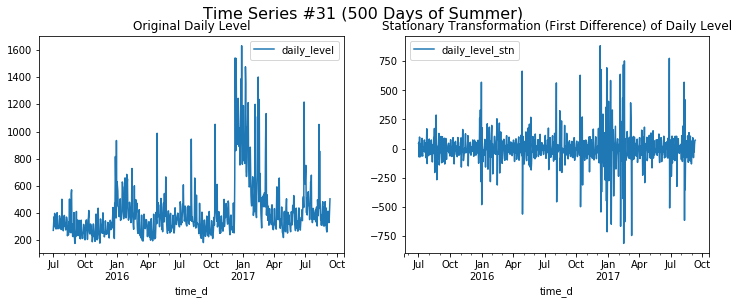

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
fig.suptitle("Time Series #31 (500 Days of Summer)", fontsize=16)

ex3d_plotdata.loc[:,["daily_level"]].plot(title="Original Daily Level", ax=ax[0])
ex3dStn_plotdata.loc[:,["daily_level_stn"]].plot(title="Stationary Transformation (First Difference) of Daily Level", ax=ax[1])

plt.show()

Of the series that were kept at the original daliy level, about half needed an additional difference transformation to be stationary, but only a small handful needed a seasonal difference. As the initial transformation becomes more aggressive, fewer additional transformations were needed. In particular, nearly all of the daily level series needed an additional difference transformation to be stationary. Most of the weekly level did not need an additional transformation compared to the daily level, and even less of the weekly growth transformed needed a transformation compared to the weekly level. None needed a log transformation.

In [19]:
tab_stn_breakdown = ts_stn_params.groupby(["variable","found_stn","func","d","D"]).size().to_frame("num_ts")
display(HTML(tab_stn_breakdown.to_html()))

## Fitting Component Models

Twelve models were initially fit. Four models will be seasonal ARIMA models based off the four data transformations. Four more will be build off seasonal ARIMA models but on the aggregated data where page views are added up by project, access, and agent, and then re-allocated back to the time series level. The final four models will be based off summary statistics. These initial twelve models will be used later to construct an ensemble model which will produce a forecast.

| Model # | Model Type                           | Model                         | Necessary Back Transformations  |
| -------:| ------------------------------------:|:----------------------------- |:----- |
|  1      | Individual Time Series (SARIMA)      | Daily Level                   | None needed |
|  2      |  Individual Time Series (SARIMA)      | Daily W-o-W Growth            | Convert daily growth to daily level |
|  3      |  Individual Time Series (SARIMA)      | Weekly Level                  | Re-seasonalize to daily |
|  4      |  Individual Time Series (SARIMA)      | Weekly W-o-W Growth           | Convert weekly growth to weekly level, <br>then re-seasonalize to daily |
|  5      |  Aggregated Time Series (SARIMA)      | Daily Level                   | Same as for individual time series, <br>then reallocate the aggregated to <br>individual time series by fixed proportions |
|  6      |  Aggregated Time Series (SARIMA)      | Daily W-o-W Growth            | Same as for individual time series, <br>then reallocate the aggregated to <br>individual time series by fixed proportions  |
|  7      |  Aggregated Time Series (SARIMA)      | Weekly Level                  | Same as for individual time series, <br>then reallocate the aggregated to <br>individual time series by fixed proportions  |
|  8      |  Aggregated Time Series (SARIMA)      | Weekly W-o-W Growth           | Same as for individual time series, <br>then reallocate the aggregated to <br>individual time series by fixed proportions  |
|  9      |  Summary Statistics                   | Seasonal Mean, All Data       |  |
| 10      |  Summary Statistics                   | Seasonal Mean, Last 60 Days   |  |
| 11      |  Summary Statistics                   | Seasonal Median, All Data     |  |
| 12      |  Summary Statistics                   | Seasonal Median, Last 60 Days |  |




### Choosing Hyperparameters and Fitting ARIMA Models to Individual and Aggregated Time Series

An ARIMA model has three parameters, the autoregressive order (AR), the moving average order (MA), and the level of differencing. For a seasonal ARIMA model (SARIMA), three equivalent parameters exist for the seasonal component. Since the level of differencing for both the global and the seasonal components were already chosen when a stationary transformation was selected, only four parameters need to be chosen: the global AR order, the global MA order, the seasonal AR order, and the seasonal MA order. 

To choose these hyperparameters, various models over a grid of potential hyperparameters were fit on the training sample for each time series and the hyperparameters that lead to the best SMAPE in the hold-out validation sample were chosen as the hyperparameters for that time series. The grid is 1-5 for the global AR and MA orders, and the grid is 1-2 for the seasonal AR and MA orders. 

Since there are 145,063 time series and each time series need to be fit over a large grid of potential hyperparameters, the number of potential models that needs to be fit is in the millions. This would take a long time to fit on a laptop, so the calculation was instead done on AWS EC2 where the calculation is easy to scale up.

### Back Transformations for ARIMA Models

The forecast needs to be at the level of daily views, so depending on the level of aggregation, additional back transformations may be needed.

Time series modeled as growth rates are converted back to levels.

Time series modeled at the aggregated weekly level are disaggregated back to the daily level in a manner that incorporates seasonality. This is done by summing up the total visits in the past 60 days for each day of the week, and using those proportions to allocate the forecasted weekly estimates into daily. When mapping weekly back to daily, use the historical seasonal proportions calculated from the historical seasonal proportions without the validation data.

For time series that have been aggregated together into multiple time series, they are aggregated back to the individual time series by summing up all the historically observed page visits for each time series, and that ratio is proportionally applied to disaggregated the aggregated series back to the individual series.


### Controls on ARIMA Model Outputs

To prevent ARIMA models from giving extremely high estimates after transformations, a simple trimming method is applied at ten times the maximum historically observed value per time series.


### Summary Statistics Models
Means and medians were calculated for each of the seven days of the week, and are applied by forecasting the same mean or median for each day of the week. There are referred to as the seasonal mean and seasonal median models. In additional to computing seasonal mean and median models on all the historical observation, they were also computed using just the last 60 days of data since that is the forecast window.


### Example of Fitted Initial Models

Below is an example of the 12 models fit for the Wikipedia article about the Python programming language. The blue line is the time series as observed on the validation sample, and the orange line is the model prediction for a particular model on the validation sample. Some models clearly work better than others, which is accounted for in the process of creating the ensemble model, which accounts for the performance of each model on the validation sample.


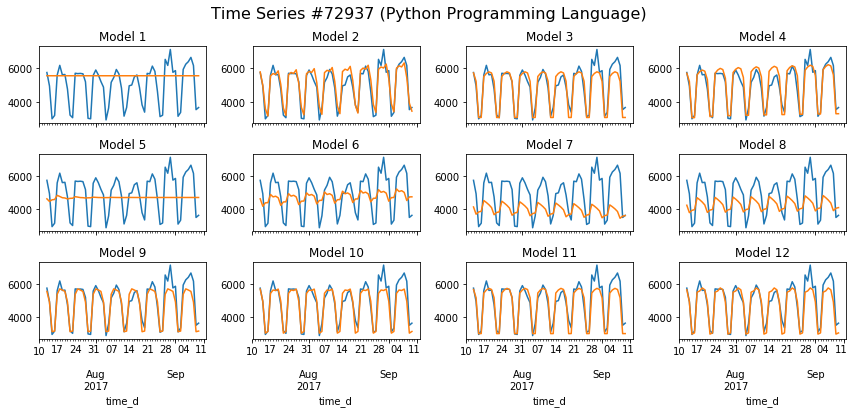

In [20]:
x1 = ["daily_level",
      "mod_ts_daily_level_BtTrim","mod_ts_daily_wowGr_BtTrim","mod_ts_weekly_level_BtTrim","mod_ts_weekly_wowGr_BtTrim"]
x2 = ["daily_level",
      "mod_agg_daily_level_BtTrim","mod_agg_daily_wowGr_BtTrim","mod_agg_weekly_level_BtTrim","mod_agg_weekly_wowGr_BtTrim"]
x3 = ["daily_level",
      "mod_sstat_mean_overall","mod_sstat_median_overall","mod_sstat_mean_last60","mod_sstat_median_last60"]

ex_models_vali = example_model_time_series_d[72937]["comp_vali"]

fig, ax = plt.subplots(3, 4, figsize=(12,6), sharex=True)
fig.suptitle("Time Series #72937 (Python Programming Language)", fontsize=16)

for i in [1,2,3,4]:
    ex_models_vali[["daily_level",x1[i]]].plot(title="Model {}".format(i), legend=False, ax=ax[0][i-1])
for i in [5,6,7,8]:
    ex_models_vali[["daily_level",x2[i-4]]].plot(title="Model {}".format(i), legend=False, ax=ax[1][i-4-1])
for i in [9,10,11,12]:
    ex_models_vali[["daily_level",x3[i-8]]].plot(title="Model {}".format(i), legend=False, ax=ax[2][i-8-1])
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Creating Ensemble Model

Since ensemble models combine multiple models, it can produce a model that is less noisy (has lower variance) than just choosing the model with the lowest SMAPE. Also, since the ensemble in this case will combine models built on individual time series and on aggregated time series, the ensemble models may capture correlated movements because the aggregated models are blended in.



For each candidate model, the SMAPE is calculated on the hold-out validation sample, which is used to determine the ensemble weights for the ensemble meta model. The holiday adjustment is reapplied before evaluating the validation sample SMAPE so that the model selection will be based off what would be forecasted.

For each time series, each component model was then ranked by its performance on the SMAPE. The chart below shows the distribution of SMAPE according to the model rank. As seen in the chart, there is not a large change in SMAPE performance for the first few ranked models. 

The methodology used for the ensemble model will be to take the top five models for each time series and the forecast of the ensemble model will be the average of those five models weighted by inverse SMAPE.

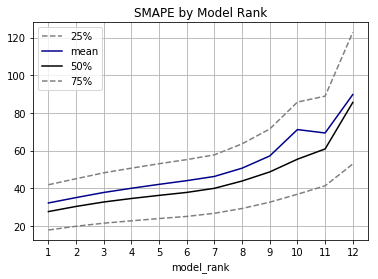

In [21]:
smape_by_model_rank = losses_byPage_modelRanked.groupby("model_rank")["smape"].describe()

smape_by_model_rank[["25%","mean","50%","75%"]].plot(
    title="SMAPE by Model Rank", 
    color=["gray","darkblue","black","gray"],
    style=["--","-","-","--"],
    xticks=range(1,13), 
    grid=True)
plt.show()

The chart on the left below shows the emphasis that would be given to each model across all pages if the top model were chosen, and the chart on the right below shows the emphasis that would be given to each model across all pages with the ensemble methodology. Using the ensemble methodology makes use of more models where choosing the model with lowest SMAPE for each time series will choose the daily level SARIMA model much of the time.

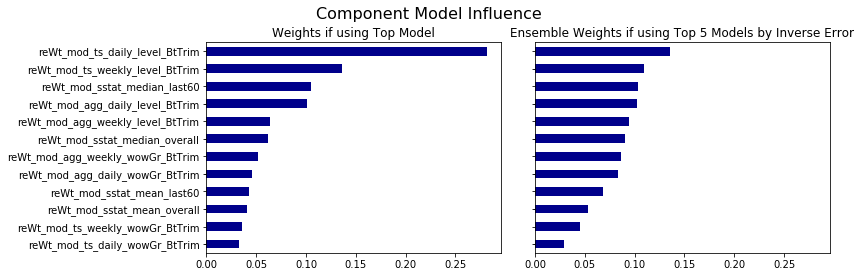

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)
fig.suptitle("Component Model Influence", fontsize=16)

ranked1_ensemble_weights.mean().sort_values(ascending=True)\
    .plot.barh(title="Weights if using Top Model", color="darkblue", ax=ax[0])

ranked5_ensemble_weights.mean().sort_values(ascending=True)\
    .plot.barh(title="Ensemble Weights if using Top 5 Models by Inverse Error", color="darkblue", ax=ax[1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

After the end of the competition and waiting 60 days for the testing sample to be collected, the performance between using the most with the lowest SMAPE versus using the ensemble methodology can be compared. As seen in the chart below, **using the ensemble model that blends the top five models weighted by inverse error results in a model with better SMAPE on the testing sample than using just the top model determined on the validation sample**.

In [23]:
losses_submission_solution = pd.read_csv(
    output_fldrpath + "/losses_submission_solution.csv",
    index_col=0)

tab1 = losses_submission_solution.loc[["postValiMod_ens_ranked1","postValiMod_ens_ranked5"]]
display(HTML(tab1.to_html()))

,smape
model,
postValiMod_ens_ranked1,49.533987
postValiMod_ens_ranked5,48.301597


The two charts below show an example for one time series, which is the article for the Python programming language. It shows the observed (blue), the prediction when using the model with lowest SMAPE on the validation sample (orange), and the prediction when using the ensemble model (green). This is shown for both the validation sample and the forecast/test sample.

In [24]:
# plot one example
## get the model weights for this example
ex_ranked5_ensemble_weights = ranked5_ensemble_weights.loc[72937]

In [25]:
ex_top5_models = list(ex_ranked5_ensemble_weights[ex_ranked5_ensemble_weights > 0].index)
ex_top5excl1_models = [v for v in ex_top5_models if v!=ex_ranked5_ensemble_weights.idxmax()]
del ex_top5_models

ex_top5excl1_models = [v[5:] for v in ex_top5excl1_models]

In [26]:
## create the plotting data
### put validation sample data together
ex_postvali_models_vali = example_model_time_series_d[72937]["postvali_vali"]

ex_plotdata_vali1 = ex_postvali_models_vali[["daily_untouched","postValiMod_ens_ranked1","postValiMod_ens_ranked5"]]
ex_plotdata_vali2 = ex_models_vali[ex_top5excl1_models]

ex_plotdata_vali = pd.concat([ex_plotdata_vali1, ex_plotdata_vali2], axis=1)

### put forecast data together
ex_models_fore = example_model_time_series_d[72937]["comp_fore"]
ex_postvali_models_fore = example_model_time_series_d[72937]["postvali_fore"]

ex_postvali_models_fore_solution = example_model_time_series_d[72937]["fore_solution"]

ex_plotdata_fore1 = ex_postvali_models_fore[["postValiMod_ens_ranked1","postValiMod_ens_ranked5"]]
ex_plotdata_fore1 = pd.concat([ex_postvali_models_fore_solution, ex_plotdata_fore1], axis=1)
ex_plotdata_fore2 = ex_models_fore[ex_top5excl1_models]

ex_plotdata_fore = pd.concat([ex_plotdata_fore1, ex_plotdata_fore2], axis=1)

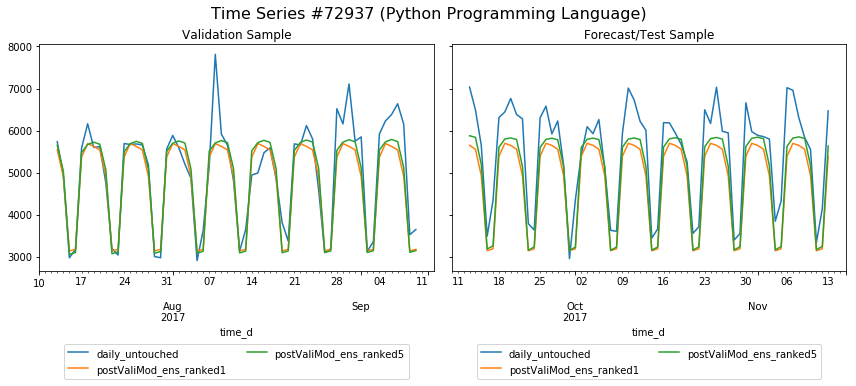

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12,5), sharey=True)
fig.suptitle("Time Series #72937 (Python Programming Language)", fontsize=16)

xvars = ["daily_untouched","postValiMod_ens_ranked1","postValiMod_ens_ranked5"]

ex_plotdata_vali[xvars].plot(
    title="Validation Sample", ax=ax[0])

ex_plotdata_fore.loc[~pd.isnull(ex_plotdata_fore["daily_untouched"]), xvars].plot(
    title="Forecast/Test Sample", ax=ax[1])

ax[0].legend(loc="upper center", bbox_to_anchor=(0.5, -0.30), ncol=2)
ax[1].legend(loc="upper center", bbox_to_anchor=(0.5, -0.30), ncol=2)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Computational Framework and Infrastructure

Since there were millions of candidate models that needed to be fit it would take a long time to fit all the models on my laptop. One way to reduce the computational time is to do the model fitting on AWS. To get a sense of what the savings in computational time could be, candidate models for approximately 100 pages were fit on my laptop and then on various AWS instances. The observed runtime to fit models on those 100 pages were extrapolated to all the pages by linearly multiplying the runtime up.

To reduce AWS costs, spot instances were used instead of on-demand instances. Also, the model fitting code was tested on a small subset of pages first before running on all the pages to minimize needing to re-run large jobs multiple times.

The table below shows estimated runtime and estimated cost from this sizing exercise. The estimated costs exclude the cost of AWS EBS storage since that cost is the same regardless of the chosen instance type and other fixed costs were excluded as well.

| Computational<br>Environment  | Estimated<br>Runtime  | Estimated<br>Cost Using<br>On-Demand<br>Instances  | Estimated<br>Cost Using<br>Spot<br>Instances  |
|:--|--:|--:|--:|
| Laptop (dual core)  | 51.8 hours  |   |   |
| AWS EC2 t2.micro (1 vCPU)  | 59.5 hours  | \$0.69  | \$0.21  |
| AWS EC2 c5.large (2 vCPU)  | 40.6 hours  | \$3.45  | \$1.22  |
| AWS EC2 c5.xlarge (4 vCPU)  | 24.5 hours  | \$4.16  | \$1.47  |
| AWS EC2 c5.2xlarge (8 vCPU) | 18.2 hours  | \$6.18  | \$2.25  |

# Kaggle Competition Results

Forecasts from this model for the next 60 days for each 145,063 time series were then submitted on Kaggle for scoring. To do so, the competition observed the next 60 days of actual traffic with the forecasts locked. This was then used to evaluate the model. This model placed in the top 18% out of 1095 entries.

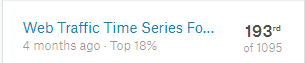

In [28]:
Image("img/kaggle_wiki_results.png", embed=True)

## Potential Enhancements

These could be potential enhancements to look into.

* Add further component models with different approachs to the ensemble process. These could be:
    * Neural network approach through LSTMs
    * ETS models
* The allocation method used to allocate the forecasted aggregated page visits back to to the individual pages is very simple, applying just the historical fixed proportion. It could be worth exploring allocating this based off modeled proportions instead of fixed proportions, such as building a model for each page's share of the total aggregated visits or repurposing one of the existing individual level models to do the allocation.